In [12]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from collections import defaultdict
import pandas as pd
from Bio import SeqIO

import matplotlib.pyplot as plt

# Setup the metadata

Pasted from the prompt. We add a mapping between the measurement ID and the number Plasmidsaurus assigns to it.

In [5]:
import pandas as pd
from io import StringIO

# Original table
metadata = pd.read_csv(StringIO(
    """
starting_stock\t0\t24\t48\t72\t96\t120
s.Ec.C.00348\tm.S.00167\tm.S.00179\tm.S.00191\tm.S.00203\tm.S.00215\tm.S.00227
s.Ec.C.00349\tm.S.00171\tm.S.00183\tm.S.00195\tm.S.00207\tm.S.00219\tm.S.00231
s.Ec.C.00350\tm.S.00175\tm.S.00187\tm.S.00199\tm.S.00211\tm.S.00223\tm.S.00235
"""), delimiter='\t')

# Melt the table into long format
metadata = metadata.melt(id_vars='starting_stock', var_name='timepoint', value_name='measurement_id')
metadata['timepoint'] = metadata['timepoint'].astype(int)
# Add measurement number by reverse lookup
measurement_id_to_number = {
    "m.S.00167": 1,
    "m.S.00171": 2,
    "m.S.00175": 3,
    "m.S.00179": 4,
    "m.S.00183": 5,
    "m.S.00187": 6,
    "m.S.00191": 7,
    "m.S.00195": 8,
    "m.S.00199": 9,
    "m.S.00203": 10,
    "m.S.00207": 11,
    "m.S.00211": 12,
    "m.S.00215": 13,
    "m.S.00219": 14,
    "m.S.00223": 15,
    "m.S.00227": 16,
    "m.S.00231": 17,
    "m.S.00235": 18
}

number_to_measurement_id = {v: k for k, v in measurement_id_to_number.items()}

metadata["measurement_number"] = metadata["measurement_id"].map(measurement_id_to_number)
# Optional: reorder columns for clarity
metadata = metadata[["measurement_number", "measurement_id", "starting_stock", "timepoint"]]

metadata = metadata.sort_values(by=['starting_stock', 'timepoint'], ascending=True)
metadata

,measurement_number,measurement_id,starting_stock,timepoint
0,1,m.S.00167,s.Ec.C.00348,0
3,4,m.S.00179,s.Ec.C.00348,24
6,7,m.S.00191,s.Ec.C.00348,48
9,10,m.S.00203,s.Ec.C.00348,72
12,13,m.S.00215,s.Ec.C.00348,96
15,16,m.S.00227,s.Ec.C.00348,120
1,2,m.S.00171,s.Ec.C.00349,0
4,5,m.S.00183,s.Ec.C.00349,24
7,8,m.S.00195,s.Ec.C.00349,48
10,11,m.S.00207,s.Ec.C.00349,72


# Read in our previously created BED files

This file has the annotations of the reads.

In [6]:
from pathlib import Path
import re

def parse_bed(f, type='cds'):
    f = Path(f)
    columns = [
        # BED12 fields
        'chrom', 'genome_start', 'genome_end', 'read_id', 'score', 'strand',
        'thickStart', 'thickEnd', 'itemRgb',
        'blockCount', 'blockSizes', 'blockStarts',
        
        # GFF fields
        'gff_chrom', 'gff_source', 'gff_type', 'gff_start', 'gff_end',
        'gff_score', 'gff_strand', 'gff_phase', 'gff_attributes',
        
        # overlap
        'overlap_bp'
    ]
    if f.stat().st_size == 0:
        print('skipping empty file', f)
        return pd.DataFrame()
    df = pd.read_csv(f, delimiter='\t', header=None, names=columns)
    df = df[df['gff_type'].str.lower() == type]
    
    return df

overlaps = []
for f in Path('output/overlaps').glob('*.bed'):
    bed = parse_bed(f)
    overlaps.append(bed)
overlaps = pd.concat(overlaps)

# Parse gff_attributes to get the meaningful qualifiers (ID, locus_tag, product)
pattern = r'ID=([^;]+);.*?locus_tag=([^;]+);.*?product=([^;]+)'
overlaps[['ID', 'locus_tag', 'product']] = overlaps['gff_attributes'].str.extract(pattern)

overlaps.head()


skipping empty file output/overlaps/YCZ4B8_13_m.S.00215.overlaps.bed
skipping empty file output/overlaps/YCZ4B8_1_m.S.00167.overlaps.bed
skipping empty file output/overlaps/YCZ4B8_16_m.S.00227.overlaps.bed


,chrom,genome_start,genome_end,read_id,score,strand,thickStart,thickEnd,itemRgb,blockCount,...,gff_start,gff_end,gff_score,gff_strand,gff_phase,gff_attributes,overlap_bp,ID,locus_tag,product
1,NC_014532.2,667101,669543,8_YCZ4B8_17,60,+,667101,669543,"0,0,0",1,...,666690,667610,.,-,0,ID=cds-WP_013331335.1;Parent=gene-HELO_RS03060...,509,cds-WP_013331335.1,HELO_RS03060,DMT family transporter
3,NC_014532.2,667101,669543,8_YCZ4B8_17,60,+,667101,669543,"0,0,0",1,...,667718,669367,.,-,0,ID=cds-WP_013331336.1;Parent=gene-HELO_RS03065...,1650,cds-WP_013331336.1,HELO_RS03065,BCCT family transporter
6,NC_014532.2,667101,667918,23_YCZ4B8_17,60,+,667101,667918,"0,0,0",1,...,666690,667610,.,-,0,ID=cds-WP_013331335.1;Parent=gene-HELO_RS03060...,509,cds-WP_013331335.1,HELO_RS03060,DMT family transporter
8,NC_014532.2,667101,667918,23_YCZ4B8_17,60,+,667101,667918,"0,0,0",1,...,667718,669367,.,-,0,ID=cds-WP_013331336.1;Parent=gene-HELO_RS03065...,201,cds-WP_013331336.1,HELO_RS03065,BCCT family transporter
11,NC_014532.2,667101,668311,9_YCZ4B8_17,60,-,667101,668311,"0,0,0",1,...,666690,667610,.,-,0,ID=cds-WP_013331335.1;Parent=gene-HELO_RS03060...,509,cds-WP_013331335.1,HELO_RS03060,DMT family transporter


# Get the barcodes file

We added another rule to our Snakefile that searches for the degenerate sequence `nnnwsnnnwsnnnwsnnnwscagannnwsnnnwsnnnwsnnnws` in our reads and creates a table with the barcode sequence found in each read.

In [7]:
from glob import glob
barcode_matches = pd.concat([pd.read_csv(f, delimiter='\t') for f in glob('output/barcodes/*')])
barcode_matches.drop(['strand', 'start', 'end'], axis=1,inplace=True)
barcode_matches.rename(columns={'matched_seq': 'barcode'}, inplace=True)
barcode_matches.head()

,read_id,barcode
0,3_YCZ4B8_12,AAAAGAAAAGATAACAAAAGCAGATTAACTTTTCTAGTGGATAC
1,4_YCZ4B8_12,GGAAGAAAAGATAACAAAAGCAGATTAACTTTTCTAGTGGATAC
2,5_YCZ4B8_12,GAAAGAAAAGATAACAAAAGCAGATTAACTTTTCTAGTGGATAC
3,7_YCZ4B8_12,AAAAGAAAAGATAACAAAAGCAGATTAACTTTTCTAGTGGATAC
4,10_YCZ4B8_12,AAAAGAAAAGATAACAAAAGCAGATTAACTTTTCTAGTGGATAC


## How many times do barcodes appear in the data?

`TGAACCCCTCACCACCGAAGCAGAGTTTGAACAGTATACAGTAC` appears 50 times, this seems interesting

In [13]:
barcode_matches['barcode'].value_counts()

barcode
TGAACCCCTCACCACCGAAGCAGAGTTTGAACAGTATACAGTAC    50
AAAAGAAAAGATAACAAAAGCAGATTAACTTTTCTAGTGGATAC    19
ATAACTATACAGTAGAAGTGCAGATATTCCTTTGTTTTCTTTTG    15
GAAAGAAAAGATAACAAAAGCAGATTAACTTTTCTAGTGGATAC     7
GGAAGAAAAGATAACAAAAGCAGATTAACTTTTCTAGTGGATAC     3
                                                ..
AGAACAATTGAAATGAAATGCAGAGTTTCTTAACCTTTCCCGTC     1
TTAAGTTTAGAATTGAATACCAGATGGTCCTTTGCGGTCTATAG     1
AAATCAAAACGAGAGTAAAGCAGAGGGAGTTTAGTACTGTTTTC     1
AGTAGCAGTGGAGAGATAACCAGACGTTCTCTTCTTTTGCATTG     1
AAATCGGAAGTACAGCATAGCAGAACTACATTAGCCCAGGCTTC     1
Name: count, Length: 152, dtype: int64

# Merge the barcode matches and the overlap file

Now we will connect the barcode sequence to the annotations.

In [14]:
barcode_annotations = overlaps.merge(barcode_matches, left_on='read_id', right_on='read_id', how='left')
barcode_annotations = barcode_annotations.pipe(lambda df: df[df['gff_attributes'].str.contains('ID=cds')])
barcode_annotations['ID'] = barcode_annotations['gff_attributes'].str.split(';').str[0].str.split('=').str[1]
barcode_annotations = barcode_annotations.dropna(subset=['barcode'])

barcode_annotations['read_num'] = barcode_annotations['read_id'].str.split('_').str[0]
barcode_annotations['measurement_num'] = barcode_annotations['read_id'].str.split('_').str[2].astype(int)
barcode_columns = [
    'read_id', 'read_num', 'measurement_num', 'genome_start', 'genome_end', 'overlap_bp', 'barcode', 
    'ID', 'locus_tag', 'product'
]
barcode_annotations = barcode_annotations[barcode_columns]

barcode_annotations = barcode_annotations.merge(metadata, left_on='measurement_num', right_on='measurement_number', how='left')

barcode_annotations['measurement_id'] = barcode_annotations['measurement_num'].astype(int).map(number_to_measurement_id)
barcode_annotations

,read_id,read_num,measurement_num,genome_start,genome_end,overlap_bp,barcode,ID,locus_tag,product,measurement_number,measurement_id,starting_stock,timepoint
0,8_YCZ4B8_17,8,17,667101,669543,509,TGAACCCCTCACCACCGAAGCAGAGTTTGAACAGTATACAGTAC,cds-WP_013331335.1,HELO_RS03060,DMT family transporter,17,m.S.00231,s.Ec.C.00349,120
1,8_YCZ4B8_17,8,17,667101,669543,1650,TGAACCCCTCACCACCGAAGCAGAGTTTGAACAGTATACAGTAC,cds-WP_013331336.1,HELO_RS03065,BCCT family transporter,17,m.S.00231,s.Ec.C.00349,120
2,23_YCZ4B8_17,23,17,667101,667918,509,TGAACCCCTCACCACCGAAGCAGAGTTTGAACAGTATACAGTAC,cds-WP_013331335.1,HELO_RS03060,DMT family transporter,17,m.S.00231,s.Ec.C.00349,120
3,23_YCZ4B8_17,23,17,667101,667918,201,TGAACCCCTCACCACCGAAGCAGAGTTTGAACAGTATACAGTAC,cds-WP_013331336.1,HELO_RS03065,BCCT family transporter,17,m.S.00231,s.Ec.C.00349,120
4,9_YCZ4B8_17,9,17,667101,668311,509,TGAACCCCTCACCACCGAAGCAGAGTTTGAACAGTATACAGTAC,cds-WP_013331335.1,HELO_RS03060,DMT family transporter,17,m.S.00231,s.Ec.C.00349,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,16_YCZ4B8_2,16,2,3756524,3756973,186,AATAGAGCACCAGACTATTGCAGATAGTCAGTAGTCAAGGATTG,cds-WP_041602259.1,HELO_RS17595,hypothetical protein,2,m.S.00171,s.Ec.C.00349,0
298,16_YCZ4B8_2,16,2,3756524,3756973,256,AATAGAGCACCAGACTATTGCAGATAGTCAGTAGTCAAGGATTG,cds-WP_013333952.1,HELO_RS17600,hypothetical protein,2,m.S.00171,s.Ec.C.00349,0
299,16_YCZ4B8_2,16,2,3756524,3756973,2,AATAGAGCACCAGACTATTGCAGATAGTCAGTAGTCAAGGATTG,cds-WP_013333953.1,HELO_RS17605,hypothetical protein,2,m.S.00171,s.Ec.C.00349,0
300,89_YCZ4B8_2,89,2,4006069,4006576,507,GATAGAATACAAGAGGGATCCAGACGTTCGCTTCATCACTGCTC,cds-WP_013334175.1,HELO_RS18805,phosphate ABC transporter permease PstA,2,m.S.00171,s.Ec.C.00349,0


In [15]:
barcode_annotations.query('barcode == "TGAACCCCTCACCACCGAAGCAGAGTTTGAACAGTATACAGTAC"')

,read_id,read_num,measurement_num,genome_start,genome_end,overlap_bp,barcode,ID,locus_tag,product,measurement_number,measurement_id,starting_stock,timepoint
0,8_YCZ4B8_17,8,17,667101,669543,509,TGAACCCCTCACCACCGAAGCAGAGTTTGAACAGTATACAGTAC,cds-WP_013331335.1,HELO_RS03060,DMT family transporter,17,m.S.00231,s.Ec.C.00349,120
1,8_YCZ4B8_17,8,17,667101,669543,1650,TGAACCCCTCACCACCGAAGCAGAGTTTGAACAGTATACAGTAC,cds-WP_013331336.1,HELO_RS03065,BCCT family transporter,17,m.S.00231,s.Ec.C.00349,120
2,23_YCZ4B8_17,23,17,667101,667918,509,TGAACCCCTCACCACCGAAGCAGAGTTTGAACAGTATACAGTAC,cds-WP_013331335.1,HELO_RS03060,DMT family transporter,17,m.S.00231,s.Ec.C.00349,120
3,23_YCZ4B8_17,23,17,667101,667918,201,TGAACCCCTCACCACCGAAGCAGAGTTTGAACAGTATACAGTAC,cds-WP_013331336.1,HELO_RS03065,BCCT family transporter,17,m.S.00231,s.Ec.C.00349,120
4,9_YCZ4B8_17,9,17,667101,668311,509,TGAACCCCTCACCACCGAAGCAGAGTTTGAACAGTATACAGTAC,cds-WP_013331335.1,HELO_RS03060,DMT family transporter,17,m.S.00231,s.Ec.C.00349,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,14_YCZ4B8_8,14,8,668977,669541,390,TGAACCCCTCACCACCGAAGCAGAGTTTGAACAGTATACAGTAC,cds-WP_013331336.1,HELO_RS03065,BCCT family transporter,8,m.S.00195,s.Ec.C.00349,48
157,3_YCZ4B8_8,3,8,669057,669543,310,TGAACCCCTCACCACCGAAGCAGAGTTTGAACAGTATACAGTAC,cds-WP_013331336.1,HELO_RS03065,BCCT family transporter,8,m.S.00195,s.Ec.C.00349,48
158,30_YCZ4B8_8,30,8,669116,669543,251,TGAACCCCTCACCACCGAAGCAGAGTTTGAACAGTATACAGTAC,cds-WP_013331336.1,HELO_RS03065,BCCT family transporter,8,m.S.00195,s.Ec.C.00349,48
159,32_YCZ4B8_8,32,8,669218,669543,149,TGAACCCCTCACCACCGAAGCAGAGTTTGAACAGTATACAGTAC,cds-WP_013331336.1,HELO_RS03065,BCCT family transporter,8,m.S.00195,s.Ec.C.00349,48


# Do we need deeper sequencing?

We'll sample the data and plot our sequencing depth vs. the number of barcodes we sequenced. If the plot plateaus, we have achieved sufficient sequencing depth.

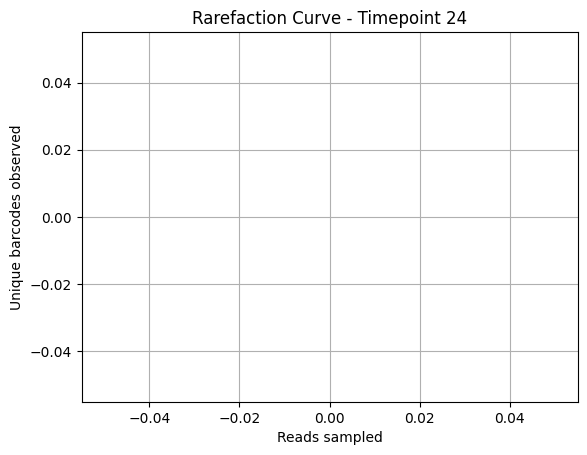

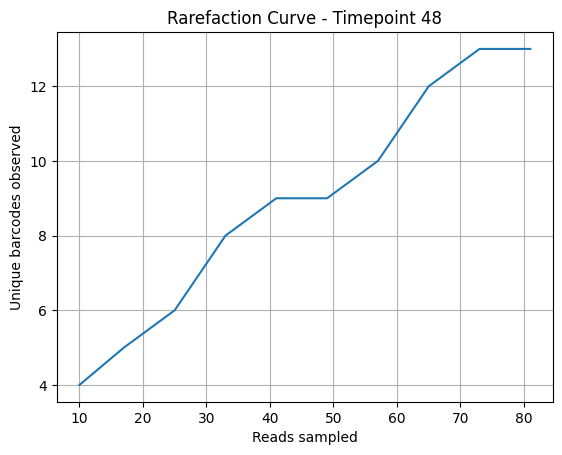

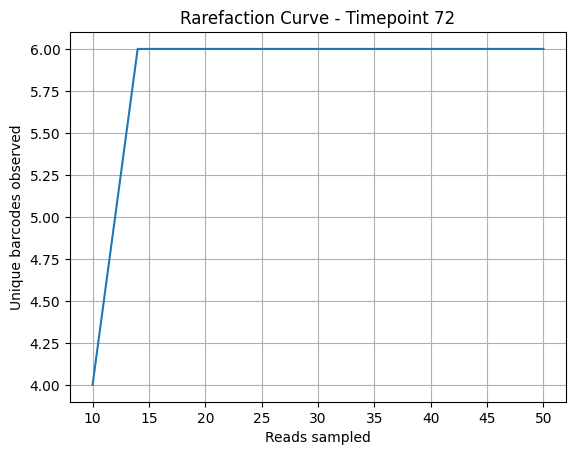

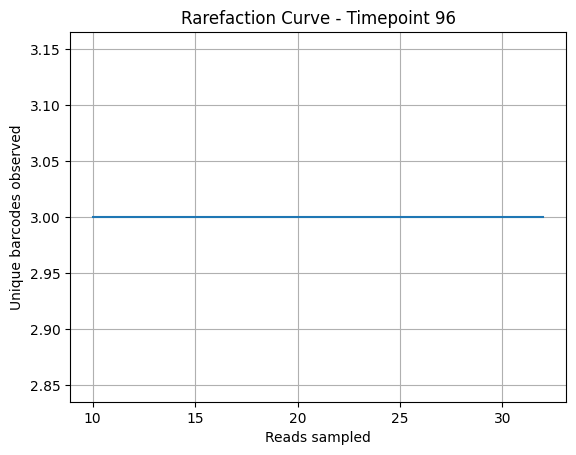

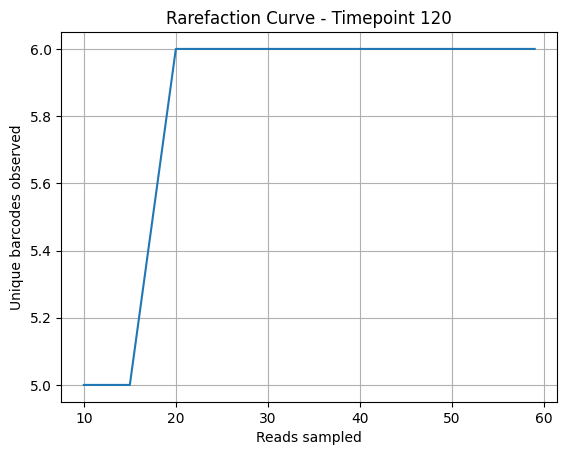

In [16]:
from sklearn.utils import resample
import numpy as np

def rarefaction_curve(df, barcode_col='barcode', max_steps=10):
    n_reads = len(df)
    if n_reads < 2:
        return [0], [0]
    
    steps = min(max_steps, n_reads)
    sizes = np.linspace(10, n_reads, steps, dtype=int)
    sizes = np.unique(sizes)  # ensure unique values for sampling
    
    barcode_counts = []
    for s in sizes:
        sampled = df.sample(n=s, replace=False, random_state=42)
        barcode_counts.append(sampled[barcode_col].nunique())
    return sizes, barcode_counts


timepoints = [24, 48, 72, 96, 120]
for timepoint in timepoints:
    df_tp = barcode_annotations[barcode_annotations['timepoint'] == timepoint]
    sizes, counts = rarefaction_curve(df_tp)

    _ = plt.plot(sizes, counts)
    _ = plt.xlabel("Reads sampled")
    _ = plt.ylabel("Unique barcodes observed")
    _ = plt.title(f"Rarefaction Curve - Timepoint {timepoint}")
    _ = plt.grid(True)
    _ = plt.show()


Text(0.5, 1.0, 'Timepoint 0')

Text(0.5, 0, 'Reads sampled')

Text(0, 0.5, 'Unique barcodes')

Text(0.5, 1.0, 'Timepoint 48')

Text(0.5, 0, 'Reads sampled')

Text(0, 0.5, 'Unique barcodes')

Text(0.5, 1.0, 'Timepoint 72')

Text(0.5, 0, 'Reads sampled')

Text(0, 0.5, 'Unique barcodes')

Text(0.5, 1.0, 'Timepoint 96')

Text(0.5, 0, 'Reads sampled')

Text(0, 0.5, 'Unique barcodes')

Text(0.5, 1.0, 'Timepoint 120')

Text(0.5, 0, 'Reads sampled')

Text(0, 0.5, 'Unique barcodes')

Text(0.5, 1.06, 'Rarefaction Curves by Timepoint (Colored by Starting Stock)')

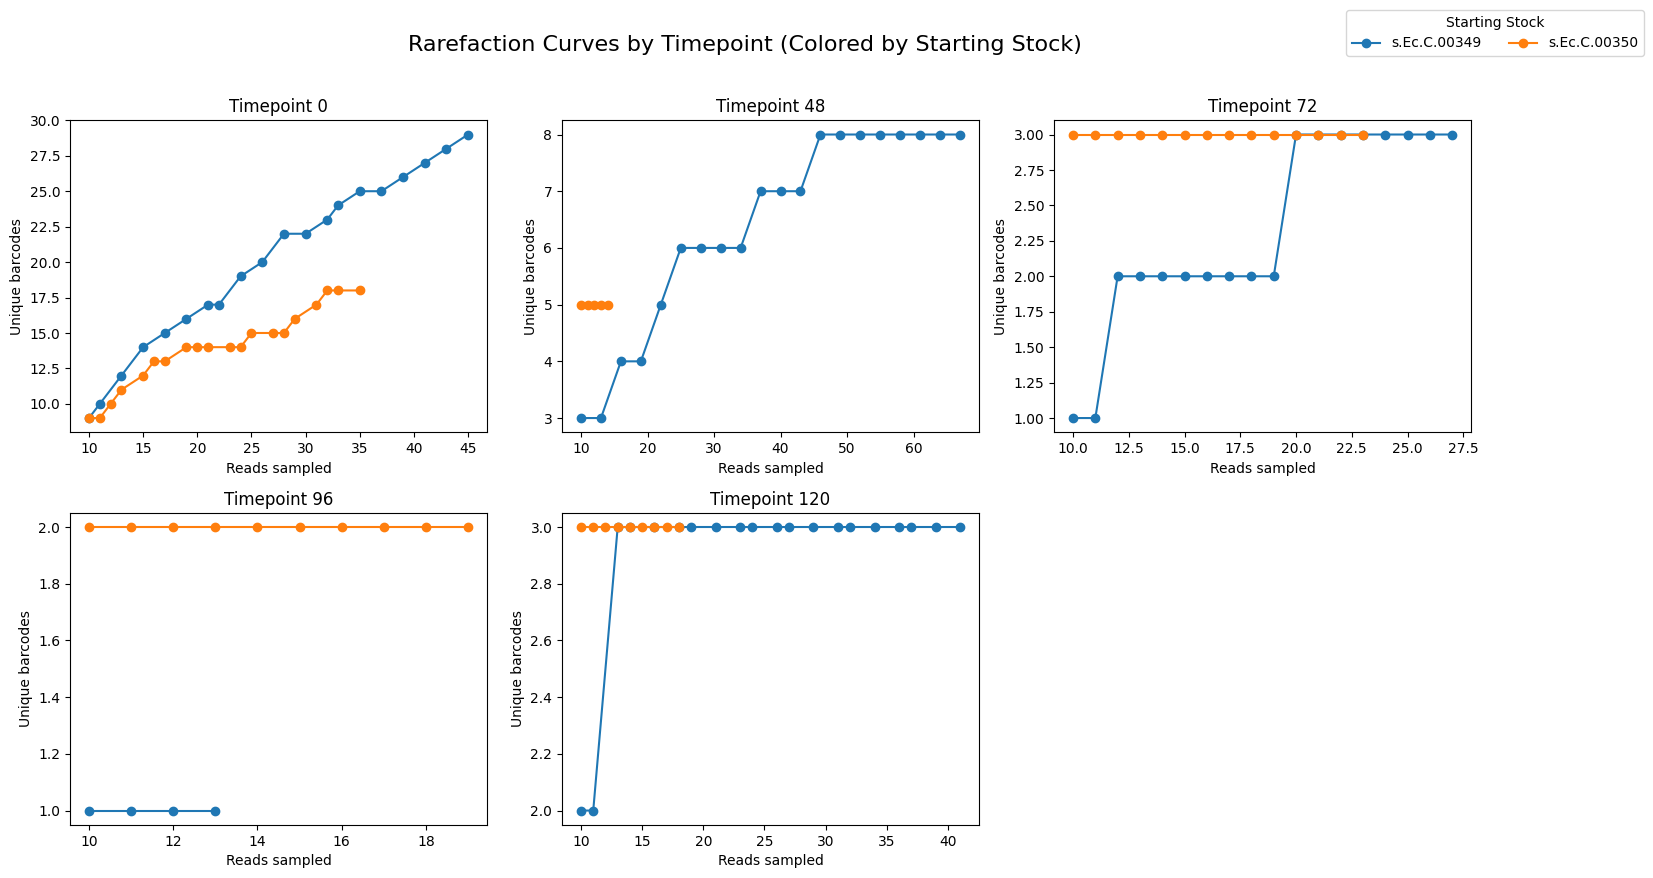

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def rarefaction_curve(df, barcode_col='barcode', max_steps=20):
    n_reads = len(df)
    if n_reads < 2:
        return [0], [0]
    
    steps = min(max_steps, n_reads)
    sizes = np.linspace(10, n_reads, steps, dtype=int)
    sizes = np.unique(sizes)
    barcode_counts = []

    for s in sizes:
        sampled = df.sample(n=s, replace=False, random_state=42)
        barcode_counts.append(sampled[barcode_col].nunique())
    
    return sizes, barcode_counts

# Set up color palette for starting stocks
stocks = sorted(barcode_annotations['starting_stock'].unique())
colors = dict(zip(stocks, plt.cm.tab10.colors[:len(stocks)]))

# Timepoints ordered numerically
timepoints = sorted(barcode_annotations['timepoint'].unique())

# One figure with subplots for each timepoint
n_cols = 3
n_rows = int(np.ceil(len(timepoints) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharex=False, sharey=False)
axes = axes.flatten()

for i, tp in enumerate(timepoints):
    ax = axes[i]
    df_tp = barcode_annotations[barcode_annotations['timepoint'] == tp]
    
    for stock in stocks:
        df_sub = df_tp[df_tp['starting_stock'] == stock]
        if len(df_sub) == 0:
            continue
        sizes, counts = rarefaction_curve(df_sub)
        ax.plot(sizes, counts, label=stock, color=colors[stock], marker='o')
    
    ax.set_title(f"Timepoint {tp}")
    ax.set_xlabel("Reads sampled")
    ax.set_ylabel("Unique barcodes")

# Remove any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title="Starting Stock", loc='upper center', bbox_to_anchor=(1, 1.1), ncol=len(stocks))

plt.tight_layout()
plt.suptitle("Rarefaction Curves by Timepoint (Colored by Starting Stock)", y=1.06, fontsize=16)
plt.show()
